particle_CLUEStering: No data found in Event 0 of histo_two.
particle_CLUEStering: No data found in Event 36 of histo_two.
particle_CLUEStering: No data found in Event 82 of histo_two.
No tracksters found for CLUEstering in Event 456 of histo_two.
**********************************************************************
No tracksters found for CLUEstering in Event 540 of histo_two.
**********************************************************************
No tracksters found for CLUEstering in Event 594 of histo_two.
**********************************************************************
No tracksters found for CLUEstering in Event 963 of histo_two.
**********************************************************************
particle_CLUE3D_Sim: No data found in Event 0 of histo_two.
particle_CLUE3D_Sim: No data found in Event 36 of histo_two.
particle_CLUE3D_Sim: No data found in Event 82 of histo_two.
No tracksters found for CLUE3D in Event 456 of histo_two.
***************************************

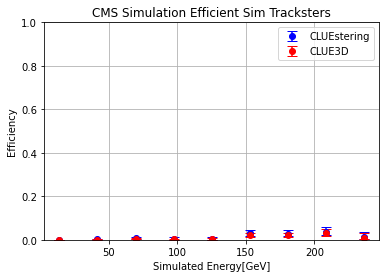

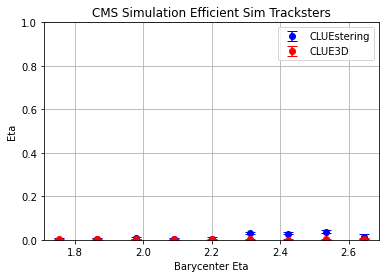

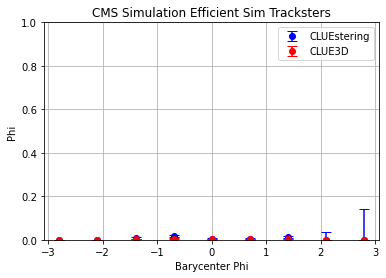

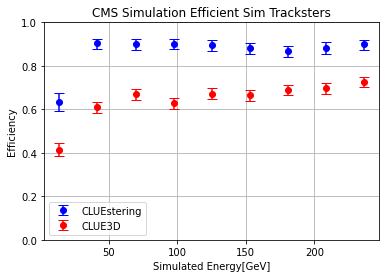

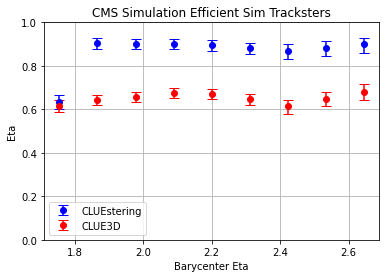

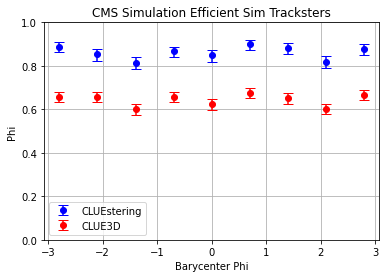

Pipeline completed.


In [23]:
import random as rnd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs
from math import sqrt
import pandas as pd
import seaborn as sns
import CLUEstering as clue
import uproot
import pandas as pd
import awkward as ak
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, QuantileTransformer
import os
import math
from scipy.stats import zscore
from collections import Counter
from scipy import stats
     
def load_LC_data(root_name):
    """
    Load the required tree data from the ROOT file.

    Input:
    - root_name (str): Name of the ROOT file (without '.root' extension).

    Output:
    - branches (dict): Extracted branches as arrays containing:
        - 'position_x': x-coordinates of cluster positions.
        - 'position_y': y-coordinates of cluster positions.
        - 'position_z': z-coordinates of cluster positions.
        - 'energy': Energy values of clusters.    
    """
    file_path = f'rootfiles/{root_name}.root'
    with uproot.open(file_path) as file:
        tree = file["ticlDumper/clusters;1"]
        branches = tree.arrays(['position_x', 'position_y', 'position_z', 'energy'])
        
    return branches

def get_event_LC_data(event_id, branches):
    """
    Extract and structure data for a specific event ID from ROOT branches.

    Input:
    - event_id (int): The ID of the event to process.
    - branches (dict): Dictionary containing the branches of data for the ROOT file, with:
        - 'position_x': Array of x-coordinates of cluster positions.
        - 'position_y': Array of y-coordinates of cluster positions.
        - 'position_z': Array of z-coordinates of cluster positions.
        - 'energy': Array of energy values of clusters.

    Output:
    - event_data (pd.DataFrame): A DataFrame containing the following columns:
        - 'x0': x-coordinates of the event clusters.
        - 'x1': y-coordinates of the event clusters.
        - 'x2': z-coordinates of the event clusters.
        - 'weight': Energy weights of the clusters.
        - 'indices': Indices of clusters in the event.
    """
    x0, x1, x2 = branches['position_x'][event_id], branches['position_y'][event_id], branches['position_z'][event_id]
    weight = branches['energy'][event_id]
    event_data = pd.DataFrame({'x0': x0, 'x1': x1, 'x2': x2, 'weight': weight, 'indices': list(range(len(x0)))})   
    return event_data

def store_stat_values(root_name, event_id, event_data):
    """
    Record the minimum, maximum, mean, and standard deviation of spatial coordinates (x0, x1, x2) 
    in the event data for normalization or scaling purposes.

    Input:
    - root_name (str): The name of the ROOT file being processed.
    - event_id (int): The ID of the event whose data is being processed.
    - event_data (pd.DataFrame): A DataFrame containing the event data with columns:
        - 'x0': x-coordinates of the clusters.
        - 'x1': y-coordinates of the clusters.
        - 'x2': z-coordinates of the clusters.

    Output: None
    """
    # Store min, max, mean, and std for each feature (x0, x1, x2)
    Original_stat_values[root_name][event_id] = {
        'x0': {
            'min': event_data['x0'].min(),
            'max': event_data['x0'].max(),
            'mean': event_data['x0'].mean(),
            'std': event_data['x0'].std()
        },
        'x1': {
            'min': event_data['x1'].min(),
            'max': event_data['x1'].max(),
            'mean': event_data['x1'].mean(),
            'std': event_data['x1'].std()
        },
        'x2': {
            'min': event_data['x2'].min(),
            'max': event_data['x2'].max(),
            'mean': event_data['x2'].mean(),
            'std': event_data['x2'].std()
        }
    }
    
def load_scaled_data(root_name, event_id, scaled_data_folder):
    """
    Load the pre-scaled data for a specific event from a CSV file.

    Input:
    - root_name (str): The name of the ROOT file being processed (not used in the function but kept for consistency).
    - event_id (int): The ID of the event for which the scaled data is loaded.
    - scaled_data_folder (str): The directory path where the scaled event data CSV files are stored.

    Output:
    - scaled_data (pd.DataFrame or None): A DataFrame containing the scaled data for the specified event, 
      or None if the event data is empty or doesn't exist.
    """
    file_path = os.path.join(scaled_data_folder, f'event_data_{event_id}.csv')
    
    # Check if the file exists and is not empty
    if not os.path.exists(file_path) or os.path.getsize(file_path) == 0:
        print(f"Warning: Event {event_id} has no data (file is missing or empty). Skipping event.")
        return None
    
    # Load the data
    scaled_data = pd.read_csv(file_path)
    
    # Check if the dataframe is empty
    if scaled_data.empty:
        print(f"Warning: Event {event_id} contains no data. Skipping event.")
        return None
    
    return scaled_data

def plot_data_trend(event_data):
    """
    Plot the trends of x0, x1, and x2 coordinates over the event's indices.

    Input:
    - event_data (pd.DataFrame): A DataFrame containing the event data, which must include columns 'x0', 'x1', and 'x2'.
      Each column represents a coordinate that is plotted over the event's indices.

    Output: None
    """
    plt.figure(figsize=(9, 6))
    for i, column in enumerate(['x0', 'x1', 'x2'], 1):
        plt.subplot(3, 1, i)  
        plt.plot(event_data[column], marker='o', linestyle='-', alpha=0.5)  
        plt.title(f'Pattern of {column}')
        plt.xlabel('Index')
        plt.ylabel(column)
    plt.tight_layout()
    plt.show()
    

def apply_save_clustering(root_name, event_id, cluestering_input_df, paramset, output_folder):
    """
    Apply the CLUEstering algorithm to the input DataFrame. Plot and save the clustering results as a CSV file.

    Input:
    - root_name (str): The name of the ROOT file (used to generate output file paths).
    - event_id (int): The ID of the event being processed (used to name the output CSV file).
    - cluestering_input_df (pd.DataFrame): The input DataFrame containing the data to be clustered.
    - paramset (list): A list containing the parameters for the CLUEstering algorithm.
    - output_folder (str): The folder where the results CSV file will be saved.

    Output:
    - clustering_output_path (str): The file path of the saved clustering results in CSV format.
    """
    clust = clue.clusterer(paramset[0], paramset[1], paramset[2])
    clust.read_data(cluestering_input_df)
    clust.run_clue()
    # clust.cluster_plotter()
    os.makedirs(output_folder, exist_ok=True)
    output_path = root_name + "/CLUESteringResults_" + str(event_id) + ".csv"
    # print(f"Event {event_id} successfully clustered and written in {output_path}")
    clust.to_csv('./CLUEsteringOutput/',output_path)
    clustering_output_path = './CLUEsteringOutput/'+output_path
    return clustering_output_path

def inverse_normalize_all_features_by_event_z_score(event_data, event_stats):
    event_data['x0'] = event_data['x0'] * event_stats['x0']['std'] + event_stats['x0']['mean']
    event_data['x1'] = event_data['x1'] * event_stats['x1']['std'] + event_stats['x1']['mean']
    event_data['x2'] = event_data['x2'] * event_stats['x2']['std'] + event_stats['x2']['mean']
    return event_data
 
def CLUEStering_trackster_properties(root_name, event_id, grouped_data):
    """
    Calculate trackster properties such as energy, size, and barycenter, and store them.

    Input:
    - root_name (str): The name of the ROOT file (e.g., 'histo_442306_2').
    - event_id (int): The ID of the event to process.
    - grouped_data (iterable): The grouped data where each group corresponds to a cluster. 
                               Each group contains 'weight', 'x0', 'x1', 'x2', and 'indices' columns.

    Output:
    - CLUEstering_results (dict): A dictionary storing trackster properties for each event
    """
    CLUEstering_tracksters_list = []
    total_number_LCs, number_clustered_LCs = 0, 0

    for cluster_id, group in grouped_data:
        total_number_LCs += len(group)
        if cluster_id != -1:            
            total_energy = group['weight'].sum()
            size = len(group)
            barycenter_x = (group['x0'] * group['weight']).sum() / total_energy
            barycenter_y = (group['x1'] * group['weight']).sum() / total_energy
            barycenter_z = (group['x2'] * group['weight']).sum() / total_energy
                 
            barycenter_phi = math.atan(barycenter_y / barycenter_x)
            theta = math.atan((math.sqrt(barycenter_x**2 + barycenter_y**2)) / barycenter_z)
            barycenter_eta = -math.log(math.tan(theta / 2))
            
            layer_indices = group['indices'].tolist()
            min_x2_idx, max_x2_idx = group['x2'].idxmin(), group['x2'].idxmax()
            CLUEstering_tracksters_list.append({
                "trackster_id": cluster_id,
                "first_layer_cluster": group.loc[min_x2_idx, ['x0', 'x1', 'x2', 'weight', 'indices']].to_dict(),
                "last_layer_cluster": group.loc[max_x2_idx, ['x0', 'x1', 'x2', 'weight', 'indices']].to_dict(),
                "layer_cluster_indices": layer_indices,
                "total_energy": total_energy,
                "size": size,
                "barycenter_x": barycenter_x,
                "barycenter_y": barycenter_y,
                "barycenter_z": barycenter_z,
                "barycenter_phi": barycenter_phi,
                "barycenter_eta": barycenter_eta
            })
            # print(f"  Trackster {cluster_id} has energy {total_energy} and size {size}")        
            number_clustered_LCs += size
        
        
    # print(f'Total LCs in Event {total_number_LCs}')
    # print(f'No. of clustered LCs {number_clustered_LCs}')

    fraction = number_clustered_LCs / total_number_LCs if total_number_LCs > 0 else 0

    CLUEstering_results[root_name][event_id] = {
        "number_of_tracksters": len(CLUEstering_tracksters_list),
        "tracksters": CLUEstering_tracksters_list,
        "fraction": fraction
    }
    # print(f"No. of tracksters: {CLUEstering_results[root_name][event_id]['number_of_tracksters']}\n")


def get_max_energy_trackster(root_name, event_id, event_tracksters, data_type):
    """
    Find the trackster with the maximum energy for a specific event.

    Input:
    - root_name (str): The name of the ROOT file being processed (e.g., 'histo_442306_2').
    - event_id (int): The ID of the event to process. This is used to identify which event’s tracksters to analyze.
    - event_tracksters (list): A list of trackster dictionaries for the given event. Each dictionary contains properties like 'trackster_id' and 'total_energy'.
    - data_type (str): The type of data being used. It should be one of the following:
        - "CLUEstering" for CLUEstering data.
        - "CLUE3D" for CLUE3D data.
        - "sim" for simulation data.

    Output:
    - dict: The trackster with the maximum energy for the specified event. This dictionary includes properties such as 'trackster_id' and 'total_energy'.
    - The maximum energy trackster is stored in a global dictionary based on the `root_name` and `event_id`.
    """
          
    if data_type == "CLUEstering":
        max_energy_tracksters = CLUEstering_max_energy_tracksters
    elif data_type == "CLUE3D":
        max_energy_tracksters = CLUE3D_max_energy_tracksters
    elif data_type == "sim":
        max_energy_tracksters = sim_max_energy_tracksters
    else:
        raise ValueError(f"Invalid data_type: {data_type}. Expected string of 'CLUEstering','CLUE3D' or 'sim'.")

    if not event_tracksters:  # Check if empty
        print(f"No tracksters found for {data_type} in Event {event_id} of {root_name}.")
        max_energy_tracksters[root_name][event_id] = None  # Store None for empty case
        print(f"**********************************************************************")
        return

    # Find the trackster with the maximum energy
    event_max_energy_trackster = max(event_tracksters, key=lambda trackster: trackster['total_energy'])
    max_energy_tracksters[root_name][event_id] = event_max_energy_trackster    
    
    # print(f"Event {event_id}: Trackster with Maximum Energy")
    # print(f"  Trackster ID: {event_max_energy_trackster['trackster_id']}")
    # print(f"  Total Energy: {event_max_energy_trackster['total_energy']}")


def load_GT_data(root_name, tree_name):
    """
    Load the required tree data from the ROOT file as the Ground Truth data.

    Input:
    - root_name (str): The name of the ROOT file being processed (e.g., 'histo_442306_2').
    - tree_name (str): The name of the tree within the ROOT file (e.g., 'ticlDumper/clusters;1').

    Output:
    - branches (dict): A dictionary containing the relevant data from the ROOT file. The dictionary has keys such as:
        - 'vertices_indexes': List of indexes corresponding to the vertices.
        - 'vertices_energy': List of energy values of the vertices.
        - 'barycenter_x', 'barycenter_y', 'barycenter_z': Lists of barycenter coordinates for each vertex.
        - 'vertices_multiplicity': List of multiplicity for each vertex.    
        - 'barycenter_eta', 'barycenter_phi': Lists of eta and phi barycenter coordinates for each vertex.
    """
    file_path = f'rootfiles/{root_name}.root'
    with uproot.open(file_path) as file:
        tree = file[tree_name]
        branches = tree.arrays(['vertices_indexes', 'vertices_energy','barycenter_x','barycenter_y',
                                'barycenter_z','vertices_multiplicity','barycenter_eta','barycenter_phi'])
        
    return branches

def get_event_GT_data(event_id, branches):
    """
    Retrieve data for a specific event from the 'branches' dictionary.

    Input:
    - event_id (int): The ID of the event whose data is to be retrieved.
    - branches (dict): A dictionary where each key corresponds to a specific data attribute 

    Output:
    - vertices_indexes (list): A list containing the vertex indexes for the specified event.
    - vertices_energy (list): A list containing the energy values of the vertices for the specified event.
    - barycenters (list): A list each containing the barycenter coordinates(x,y,x,eta,phi) for the event
    - vertices_multiplicity (list): A list containing the multiplicity values of the vertices for the specified event.
    """    
    return {
        "vertices_indexes": branches["vertices_indexes"][event_id],
        "vertices_energy": branches["vertices_energy"][event_id],
        "barycenter_x": branches["barycenter_x"][event_id],
        "barycenter_y": branches["barycenter_y"][event_id],
        "barycenter_z": branches["barycenter_z"][event_id],
        "vertices_multiplicity": branches["vertices_multiplicity"][event_id],
        "barycenter_eta": branches["barycenter_eta"][event_id],
        "barycenter_phi": branches["barycenter_phi"][event_id],
    }

def read_store_tracksters_properties(root_name, event_id, raw_data_df, vertices_indexes, vertices_energy, barycenters, data_type, vertices_multiplicity=None):
    """
    Processes trackster data for a single event and stores it in global dictionaries.
    Get Max Energy trackster info and store.

    Input:
        event_id (int): The ID of the event being processed.
        root_name (str): Name of the root file being processed.
        raw_data_df (DataFrame): Raw data for the current event.
        vertices_indexes (list): Tracksters' vertices indices for the event.
        vertices_energy (list): Tracksters' energy for the event.
        barycenters (array): Tracksters' barycenters (x, y, z) for the event.
        vertices_multiplicity (list, optional): Tracksters' multiplicity (default is None).
        data_type (str): Type of data being processed. Options are "CLUE3D" or "sim".
    
    Output:
        results (dict): Global dictionary where the processed trackster data is stored. The dictionary contains:
            - "number_of_tracksters": The number of tracksters processed.
            - "tracksters": A list of dictionaries containing information about each trackster.
    """
    # Declarations    
    tracksters_list = []
    tracksters_energy = {}
    results = {
        root_name: {
            event_id: {}
        }
    }
    
    # print(f"Processing {data_type} Event {event_id} in {root_name} with {len(vertices_indexes)} tracksters...")
    for trackster_id, (trackster_indexes, trackster_energies) in enumerate(zip(vertices_indexes, vertices_energy)):

        total_energy = sum(trackster_energies)
        tracksters_energy[trackster_id] = {
            'total_energy': total_energy,
            'vertices_indexes': trackster_indexes
        }
        filtered_data = raw_data_df[raw_data_df['indices'].isin(trackster_indexes)]

        # Find indices of rows with minimum and maximum x2 values
        min_x2_idx = filtered_data['x2'].idxmin()
        max_x2_idx = filtered_data['x2'].idxmax()

        # Retrieve the rows with min and max x2 values
        first_layer = (filtered_data.loc[min_x2_idx, ['x0', 'x1', 'x2', 'weight', 'indices']]).to_dict()
        last_layer = (filtered_data.loc[max_x2_idx, ['x0', 'x1', 'x2', 'weight', 'indices']]).to_dict()

        trackster_info = {
            'trackster_id': trackster_id,
            'total_energy': total_energy,
            'layer_cluster_indices': trackster_indexes.tolist(),
            'size': len(trackster_indexes),
            'first_layer_cluster': first_layer,
            'last_layer_cluster': last_layer,
            'barycenter_x': barycenters[0][trackster_id],
            'barycenter_y': barycenters[1][trackster_id],
            'barycenter_z': barycenters[2][trackster_id],
            'barycenter_eta': barycenters[3][trackster_id],
            'barycenter_phi': barycenters[4][trackster_id]
        }

        # Include vertices_multiplicity if available
        if vertices_multiplicity is not None:
            trackster_info['vertices_multiplicity'] = vertices_multiplicity[trackster_id].tolist()

        tracksters_list.append(trackster_info)        
        
    # Store results for all tracksters
    results[root_name][event_id] = {
        "number_of_tracksters": len(tracksters_list),
        "tracksters": tracksters_list
    }
    if data_type == "CLUE3D":
        CLUE3D_results[root_name][event_id] = results[root_name][event_id]
    elif data_type == "sim":
        sim_results[root_name][event_id] = results[root_name][event_id]
    else:
        raise ValueError(f"Invalid data_type: {data_type}. Expected string of 'CLUE3D' or 'sim'.")


def plot_size_energy_single_particle(event_id, CLUEstering_event_max_trackster, CLUE3D_event_max_trackster, sim_event_max_trackster):
    """
    Plots the sizes and total energies of the tracksters for a given event across different data types (CLUEstering, CLUE3D, and simulation).
    
    Input:
    - event_id (int): The ID of the event being processed.
    - CLUEstering_event_max_trackster (dict): A dictionary containing the trackster data for the CLUEstering event. The dictionary should have:
        - 'size': The size (number of elements) of the trackster.
        - 'total_energy': The total energy of the trackster.
    - CLUE3D_event_max_trackster (dict): A dictionary containing the trackster data for the CLUE3D event. The dictionary should have:
        - 'size': The size (number of elements) of the trackster.
        - 'total_energy': The total energy of the trackster.
    - sim_event_max_trackster (dict): A dictionary containing the trackster data for the simulation event. The dictionary should have:
        - 'size': The size (number of elements) of the trackster.
        - 'total_energy': The total energy of the trackster.

    Output:
    - trackster_sizes (list): A list containing the sizes of the tracksters for the three data types in the following order: [CLUEstering, CLUE3D, Sim].
    """    
    # Trackster sizes and total energies
    trackster_sizes = [
        CLUEstering_event_max_trackster['size'], 
        CLUE3D_event_max_trackster['size'], 
        sim_event_max_trackster['size']
    ]
    trackster_energies = [
        CLUEstering_event_max_trackster['total_energy'],
        CLUE3D_event_max_trackster['total_energy'],  
        sim_event_max_trackster['total_energy']
    ]
    
    # Plot sizes in a bar chart
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.bar(['CLUEstering Trackster', 'CLUE3D Trackster', 'Sim Trackster'], trackster_sizes, color=['orange', 'blue', 'green'])
    plt.title(f"Trackster Sizes for event {event_id}")
    plt.xlabel("Trackster")
    plt.ylabel("Size")
    
    # Plot total energies in a bar chart
    plt.subplot(1, 2, 2)
    plt.bar(['CLUEstering Trackster', 'CLUE3D Trackster', 'Sim Trackster'], trackster_energies, color=['orange', 'blue', 'green'])
    plt.title(f"Total Energy of Tracksters for event {event_id}")
    plt.xlabel("Trackster")
    plt.ylabel("Total Energy")
    
    plt.tight_layout()
    plt.show()
    # plt.savefig(f"trackster_comparison_event_{event_id}.png")

    return trackster_sizes

def plot_size_energy_multi_particle(event_id, CLUEstering_tracksters, CLUE3D_tracksters, sim_tracksters):
    """
    Plots grouped bar charts for sizes and total energies of tracksters for a given event across different methods.
    Each bar group represents the method (CLUEstering, CLUE3D, Sim).
    
    Input:
    - event_id (int): The ID of the event being processed.
    - CLUEstering_tracksters (dict): The tracksters data for the CLUEstering method.
    - CLUE3D_tracksters (dict): The tracksters data for the CLUE3D method.
    - sim_tracksters (dict): The tracksters data for the simulation.
    
    Output:
    - None: The function generates and displays the plots.
    """
    # Extract sizes and energies for each method
    cluestering_sizes = [t['size'] for t in CLUEstering_tracksters['tracksters']]
    cluestering_energies = [t['total_energy'] for t in CLUEstering_tracksters['tracksters']]
    
    clue3d_sizes = [t['size'] for t in CLUE3D_tracksters['tracksters']]
    clue3d_energies = [t['total_energy'] for t in CLUE3D_tracksters['tracksters']]
    
    sim_sizes = [t['size'] for t in sim_tracksters['tracksters']]
    sim_energies = [t['total_energy'] for t in sim_tracksters['tracksters']]

    # Handle different number of tracksters by padding with zeros
    max_len = max(len(cluestering_sizes), len(clue3d_sizes), len(sim_sizes))
    cluestering_sizes += [0] * (max_len - len(cluestering_sizes))
    cluestering_energies += [0] * (max_len - len(cluestering_energies))
    
    clue3d_sizes += [0] * (max_len - len(clue3d_sizes))
    clue3d_energies += [0] * (max_len - len(clue3d_energies))
    
    sim_sizes += [0] * (max_len - len(sim_sizes))
    sim_energies += [0] * (max_len - len(sim_energies))

    # Prepare data for grouped bar charts
    indices = np.arange(max_len)  # Indices for tracksters
    bar_width = 0.25  # Width of each bar

    # Create subplots
    plt.figure(figsize=(14, 6))

    # Sizes plot
    plt.subplot(1, 2, 1)
    plt.bar(indices - bar_width, cluestering_sizes, width=bar_width, label='CLUEstering', color='orange')
    plt.bar(indices, clue3d_sizes, width=bar_width, label='CLUE3D', color='blue')
    plt.bar(indices + bar_width, sim_sizes, width=bar_width, label='Sim', color='green')
    plt.title(f"Trackster Sizes for Event {event_id}")
    plt.xlabel("Trackster Index")
    plt.ylabel("Size")
    plt.xticks(indices, [f"Trackster {i+1}" for i in range(max_len)], rotation=45)
    plt.legend()

    # Energies plot
    plt.subplot(1, 2, 2)
    plt.bar(indices - bar_width, cluestering_energies, width=bar_width, label='CLUEstering', color='orange')
    plt.bar(indices, clue3d_energies, width=bar_width, label='CLUE3D', color='blue')
    plt.bar(indices + bar_width, sim_energies, width=bar_width, label='Sim', color='green')
    plt.title(f"Trackster Energies for Event {event_id}")
    plt.xlabel("Trackster Index")
    plt.ylabel("Total Energy")
    plt.xticks(indices, [f"Trackster {i+1}" for i in range(max_len)], rotation=45)
    plt.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()


def scatter_plot_clusters_barycenters_multi_particle(event_id, event_data, reco_event_tracksters, sim_event_tracksters):
    """
    Generates scatter plots for corresponding tracksters in reco_event_tracksters and sim_event_tracksters based on the mapping.

    Parameters:
    - event_id (int): ID of the event being processed.
    - event_data (DataFrame): A pandas DataFrame containing the event data, including cluster points and their indices.
    - reco_event_tracksters (dict): Contains the number of tracksters and a list of trackster dictionaries for reco data.
    - sim_event_tracksters (dict): Contains the number of tracksters and a list of trackster dictionaries for sim data.
    - corresponding_tracksters_ids (dict): A mapping of trackster IDs between sim_event_tracksters and reco_event_tracksters.
    """
    # Check if the event_id exists in the dictionary
    if event_id not in corresponding_tracksters_ids:
        print(f"Event ID {event_id} not found in the dictionary.")
        return
    
    # Retrieve the mapping for the event_id
    mapping = corresponding_tracksters_ids[event_id]

    # Loop over the pairs of matching trackster IDs in the mapping
    for sim_trackster_id, reco_trackster_id in mapping.items():
        # Find the corresponding trackster in sim_event_tracksters and reco_event_tracksters
        sim_trackster = next((ts for ts in sim_event_tracksters["tracksters"] if ts["trackster_id"] == sim_trackster_id), None)
        reco_trackster = next((ts for ts in reco_event_tracksters["tracksters"] if ts["trackster_id"] == reco_trackster_id), None)
        
        # If either trackster is not found, skip this pair
        if not sim_trackster or not reco_trackster:
            print(f"Trackster pair {sim_trackster_id}, {reco_trackster_id} not found in the event {event_id}.")
            continue

        # Retrieve the layer cluster indices for both tracksters
        reco_indices = reco_trackster['layer_cluster_indices']
        sim_indices = sim_trackster['layer_cluster_indices']

        # Retrieve the points from event_data using the layer cluster indices
        reco_points = event_data[event_data['indices'].isin(reco_indices)]
        sim_points = event_data[event_data['indices'].isin(sim_indices)]

        # Extract barycenters for plotting
        reco_barycenter = (reco_trackster['barycenter_x'], reco_trackster['barycenter_y'], reco_trackster['barycenter_z'])
        sim_barycenter = (sim_trackster['barycenter_x'], sim_trackster['barycenter_y'], sim_trackster['barycenter_z'])

        # Initialize plot
        fig = plt.figure(figsize=(15, 10))

        # 3D scatter plot
        ax3d = fig.add_subplot(221, projection='3d')
        ax3d.scatter(
            sim_points['x0'], sim_points['x1'], sim_points['x2'],
            c='green', label="Sim Trackster Points", alpha=0.6
        )
        ax3d.scatter(
            reco_points['x0'], reco_points['x1'], reco_points['x2'],
            c='orange', label="Reco Trackster Points", alpha=0.6
        )
        ax3d.scatter(
            sim_barycenter[0], sim_barycenter[1], sim_barycenter[2],
            c='darkgreen', s=100, marker='X', label="Sim Barycenter"
        )
        ax3d.scatter(
            reco_barycenter[0], reco_barycenter[1], reco_barycenter[2],
            c='red', s=100, marker='X', label="Reco Barycenter"
        )
        ax3d.set_xlabel("x0")
        ax3d.set_ylabel("x1")
        ax3d.set_zlabel("x2")
        ax3d.set_title(f"3D Scatter Plot for Tracksters (Event {event_id})")
        ax3d.legend()

        # x0-x1 plane
        ax2d_1 = fig.add_subplot(222)
        ax2d_1.scatter(
            sim_points['x0'], sim_points['x1'],
            c='green', label="Sim Trackster Points", alpha=0.6
        )
        ax2d_1.scatter(
            reco_points['x0'], reco_points['x1'],
            c='orange', label="Reco Trackster Points", alpha=0.6
        )
        ax2d_1.scatter(
            sim_barycenter[0], sim_barycenter[1],
            c='darkgreen', s=100, marker='X', label="Sim Barycenter"
        )
        ax2d_1.scatter(
            reco_barycenter[0], reco_barycenter[1],
            c='red', s=100, marker='X', label="Reco Barycenter"
        )
        ax2d_1.set_xlabel("x0")
        ax2d_1.set_ylabel("x1")
        ax2d_1.set_title("x0-x1 Plane")

        # x1-x2 plane
        ax2d_2 = fig.add_subplot(223)
        ax2d_2.scatter(
            sim_points['x1'], sim_points['x2'],
            c='green', label="Sim Trackster Points", alpha=0.6
        )
        ax2d_2.scatter(
            reco_points['x1'], reco_points['x2'],
            c='orange', label="Reco Trackster Points", alpha=0.6
        )
        ax2d_2.scatter(
            sim_barycenter[1], sim_barycenter[2],
            c='darkgreen', s=100, marker='X', label="Sim Barycenter"
        )
        ax2d_2.scatter(
            reco_barycenter[1], reco_barycenter[2],
            c='red', s=100, marker='X', label="Reco Barycenter"
        )
        ax2d_2.set_xlabel("x1")
        ax2d_2.set_ylabel("x2")
        ax2d_2.set_title("x1-x2 Plane")

        # x0-x2 plane
        ax2d_3 = fig.add_subplot(224)
        ax2d_3.scatter(
            sim_points['x0'], sim_points['x2'],
            c='green', label="Sim Trackster Points", alpha=0.6
        )
        ax2d_3.scatter(
            reco_points['x0'], reco_points['x2'],
            c='orange', label="Reco Trackster Points", alpha=0.6
        )
        ax2d_3.scatter(
            sim_barycenter[0], sim_barycenter[2],
            c='darkgreen', s=100, marker='X', label="Sim Barycenter"
        )
        ax2d_3.scatter(
            reco_barycenter[0], reco_barycenter[2],
            c='red', s=100, marker='X', label="Reco Barycenter"
        )
        ax2d_3.set_xlabel("x0")
        ax2d_3.set_ylabel("x2")
        ax2d_3.set_title("x0-x2 Plane")

        plt.suptitle(f"Trackster Comparison for Event {event_id}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


def merge_histogram(root_name, event_reco, reco_ids_with_multiple_occurrences):
    
    # Get all reco tracksters
    all_reco_tracksters = event_reco["tracksters"]     
    all_reco_energy_values = np.array([reco["total_energy"] for reco in all_reco_tracksters])   
    all_reco_eta_values = np.array([reco["barycenter_eta"] for reco in all_reco_tracksters])   
    all_reco_phi_values = np.array([reco["barycenter_phi"] for reco in all_reco_tracksters])   
    
    Reco_performance_energy[root_name]["all_reco_energy_list"].extend(all_reco_energy_values)
    Reco_performance_eta[root_name]["all_reco_eta_list"].extend(all_reco_eta_values)
    Reco_performance_phi[root_name]["all_reco_phi_list"].extend(all_reco_phi_values)
    
    
    # Get merged reco tracksters
    if reco_ids_with_multiple_occurrences: 
        merged_reco_energy_values = np.array([all_reco_tracksters[idx]["total_energy"] for idx in reco_ids_with_multiple_occurrences]) 
        merged_reco_eta_values = np.array([all_reco_tracksters[idx]["barycenter_eta"] for idx in reco_ids_with_multiple_occurrences]) 
        merged_reco_phi_values = np.array([all_reco_tracksters[idx]["barycenter_phi"] for idx in reco_ids_with_multiple_occurrences]) 
        
        Reco_performance_energy[root_name]["merge_reco_energy_list"].extend(merged_reco_energy_values)
        Reco_performance_eta[root_name]["merge_reco_eta_list"].extend(merged_reco_eta_values)
        Reco_performance_phi[root_name]["merge_reco_phi_list"].extend(merged_reco_phi_values)

def efficiency_histogram(root_name, event_sim, efficient_sim_tracksters_list):

    # Get all sim tracksters
    all_sim_trackster_list = event_sim["tracksters"]
    all_sim_energy_values = np.array([sim["total_energy"] for sim in all_sim_trackster_list])
    all_sim_eta_values = np.array([sim["barycenter_eta"] for sim in all_sim_trackster_list])
    all_sim_phi_values = np.array([sim["barycenter_phi"] for sim in all_sim_trackster_list])
    
    Reco_performance_energy[root_name]["all_sim_energy_list"].extend(all_sim_energy_values)
    Reco_performance_eta[root_name]["all_sim_eta_list"].extend(all_sim_eta_values)
    Reco_performance_phi[root_name]["all_sim_phi_list"].extend(all_sim_phi_values)

    # Get efficient sim tracksters
    if efficient_sim_tracksters_list: 
        efficient_sim_energy_values = np.array([efficient_sim["sim energy"] for efficient_sim in efficient_sim_tracksters_list])
        efficient_sim_eta_values = np.array([efficient_sim["sim barycenter eta"] for efficient_sim in efficient_sim_tracksters_list])
        efficient_sim_phi_values = np.array([efficient_sim["sim barycenter phi"] for efficient_sim in efficient_sim_tracksters_list])
        
        Reco_performance_energy[root_name]["efficient_sim_energy_list"].extend(efficient_sim_energy_values)
        Reco_performance_eta[root_name]["efficient_sim_eta_list"].extend(efficient_sim_eta_values)
        Reco_performance_phi[root_name]["efficient_sim_phi_list"].extend(efficient_sim_phi_values)

def clopper_pearson_interval(k, n, alpha=0.32):
    efficiency = k / n
    lower_bound = stats.beta.ppf(alpha / 2, k, n - k + 1)
    upper_bound = stats.beta.ppf(1 - alpha/2, k + 1, n - k)

    lower_error = efficiency - lower_bound
    upper_error = upper_bound - efficiency

    return efficiency, lower_error, upper_error

def plot_merge_histo(root_name, bins_values, plot_type):  
    
    if plot_type == "energy":
        k, eff_bin_edges = np.histogram(Reco_performance_energy[root_name]["merge_reco_energy_list"], bins=bins_values)
        n, all_bin_edges = np.histogram(Reco_performance_energy[root_name]["all_reco_energy_list"], bins=bins_values)
       
    elif plot_type == "eta":
        k, eff_bin_edges = np.histogram(Reco_performance_eta[root_name]["merge_reco_eta_list"], bins=bins_values)
        n, all_bin_edges = np.histogram(Reco_performance_eta[root_name]["all_reco_eta_list"], bins=bins_values)
        
    elif plot_type == "phi":   
        k, eff_bin_edges = np.histogram(Reco_performance_phi[root_name]["merge_reco_phi_list"], bins=bins_values)
        n, all_bin_edges = np.histogram(Reco_performance_phi[root_name]["all_reco_phi_list"], bins=bins_values)
             
    else:
        raise ValueError(f"Invalid plot_type: {plot_type}. Expected string of 'energy', 'eta' or 'phi'.")
    
    # Error Propagation Calculation
    efficiency_list = np.array([])
    lower_error_list = np.array([])
    upper_error_list = np.array([])

    for bin in range(len(n)):
        if n[bin] == 0:
            efficiency_list = np.append(efficiency_list, 0)
            lower_error_list = np.append(lower_error_list, 0)
            upper_error_list = np.append(upper_error_list, 0)
            continue
        efficiency, lower_error, upper_error = clopper_pearson_interval(k[bin],n[bin],0.32)
        efficiency_list = np.append(efficiency_list, efficiency)
        lower_error_list = np.append(lower_error_list, lower_error)
        upper_error_list = np.append(upper_error_list, upper_error)
    
    lower_error_list = np.nan_to_num(lower_error_list, nan=0.0)
    upper_error_list = np.nan_to_num(upper_error_list, nan=0.0)
    x_axis = (bins_values[:-1] + bins_values[1:]) / 2
    y_axis = efficiency_list
    errors = [lower_error_list.tolist(), upper_error_list.tolist()]
    return x_axis.tolist(), y_axis.tolist(), errors
    # Plot the ratios
    # plt.errorbar(x_axis, efficiency_list, yerr=errors, fmt='o', capsize=5)       
    # plt.ylim(0, 1)
    # legend_label = f"Merge Reco Count  = {k}\nAll Reco Count = {n}"
    # plt.legend([legend_label])    
    # plt.ylabel('Efficiency')
    # plt.title('CMS Simulation Merge Rate')
    # if plot_type == "energy":
    #     plt.xlabel('Simulated Energy[GeV]')        
    # elif plot_type == "eta":
    #     plt.xlabel('Barycenter Eta')
    # else:
    #     plt.xlabel('Barycenter Phi')
    # plt.grid(True)
    # plt.show()    
  
def plot_efficiency_histo(root_name, bins_values, plot_type):
      
    if plot_type == "energy":
        k, eff_bin_edges = np.histogram(Reco_performance_energy[root_name]["efficient_sim_energy_list"], bins=bins_values)
        n, all_bin_edges = np.histogram(Reco_performance_energy[root_name]["all_sim_energy_list"], bins=bins_values)
        
    elif plot_type == "eta":
        k, eff_bin_edges = np.histogram(Reco_performance_eta[root_name]["efficient_sim_eta_list"], bins=bins_values)
        n, all_bin_edges = np.histogram(Reco_performance_eta[root_name]["all_sim_eta_list"], bins=bins_values)
        
    elif plot_type == "phi":   
        k, eff_bin_edges = np.histogram(Reco_performance_phi[root_name]["efficient_sim_phi_list"], bins=bins_values)
        n, all_bin_edges = np.histogram(Reco_performance_phi[root_name]["all_sim_phi_list"], bins=bins_values)
             
    else:
        raise ValueError(f"Invalid plot_type: {plot_type}. Expected string of 'energy', 'eta' or 'phi'.")
   
    # Error Propagation Calculation
    efficiency_list = np.array([])
    lower_error_list = np.array([])
    upper_error_list = np.array([])

    for bin in range(len(n)):
        if n[bin] == 0:
            efficiency_list = np.append(efficiency_list, 0)
            lower_error_list = np.append(lower_error_list, 0)
            upper_error_list = np.append(upper_error_list, 0)
            continue
        efficiency, lower_error, upper_error = clopper_pearson_interval(k[bin],n[bin],0.32)
        efficiency_list = np.append(efficiency_list, efficiency)
        lower_error_list = np.append(lower_error_list, lower_error)
        upper_error_list = np.append(upper_error_list, upper_error)
    
    lower_error_list = np.nan_to_num(lower_error_list, nan=0.0)
    upper_error_list = np.nan_to_num(upper_error_list, nan=0.0)
    x_axis = (bins_values[:-1] + bins_values[1:]) / 2
    y_axis = efficiency_list
    errors = [lower_error_list.tolist(), upper_error_list.tolist()]    
    return x_axis.tolist(), y_axis.tolist(), errors
    # Plot the error bar
    # plt.errorbar(x_axis, efficiency_list, yerr=errors, fmt='o', capsize=5)   
    # plt.ylim(0, 1)
    # plt.ylabel('Efficiency')
    # plt.title('CMS Simulation Efficient Sim Tracksters')
    # if plot_type == "energy":
    #     plt.xlabel('Simulated Energy[GeV]')        
    # elif plot_type == "eta":
    #     plt.xlabel('Barycenter Eta')
    # else:
    #     plt.xlabel('Barycenter Phi')
    # legend_label = f"Efficient Sim Count = {k}\nAll Sim Count = {n}"
    # plt.legend([legend_label])
    # plt.grid(True)
    # plt.show()   

def plot_error_bars(CLUEstering_plot_merge_values, CLUEstering_plot_efficiency_values, CLUE3D_plot_merge_values, CLUE3D_plot_efficiency_values):
    for root_name in root_names: 
        # Merge Plots
        # Plot the error bar for Energy  
        # print(CLUEstering_plot_merge_values[root_name]["x_energy"])
        # print(CLUE3D_plot_merge_values[root_name]["x_energy"])
        plt.errorbar(CLUEstering_plot_merge_values[root_name]["x_energy"], CLUEstering_plot_merge_values[root_name]["y_energy"], yerr=CLUEstering_plot_merge_values[root_name]["errors_energy"], fmt='o', capsize=5, color='blue', label='CLUEstering')   
        plt.errorbar(CLUE3D_plot_merge_values[root_name]["x_energy"], CLUE3D_plot_merge_values[root_name]["y_energy"], yerr=CLUE3D_plot_merge_values[root_name]["errors_energy"], fmt='o', capsize=5, color='red', label='CLUE3D')
        plt.ylim(0, 1)
        plt.ylabel('Efficiency')
        plt.title('CMS Simulation Efficient Sim Tracksters')       
        plt.xlabel('Simulated Energy[GeV]')      
        
        # legend_label = f"Efficient Sim Count = {k}\nAll Sim Count = {n}"
        plt.legend()
        plt.grid(True)
        plt.show()   

        # Plot the error bar for Barycenter_eta  
        plt.errorbar(CLUEstering_plot_merge_values[root_name]["x_eta"], CLUEstering_plot_merge_values[root_name]["y_energy"], yerr=CLUEstering_plot_merge_values[root_name]["errors_eta"], fmt='o', capsize=5, color='blue', label='CLUEstering')   
        plt.errorbar(CLUE3D_plot_merge_values[root_name]["x_eta"], CLUE3D_plot_merge_values[root_name]["y_eta"], yerr=CLUE3D_plot_merge_values[root_name]["errors_eta"], fmt='o', capsize=5, color='red', label='CLUE3D')
        plt.ylim(0, 1)
        plt.ylabel('Eta')
        plt.title('CMS Simulation Efficient Sim Tracksters')        
        plt.xlabel('Barycenter Eta')        
        # legend_label = f"Efficient Sim Count = {k}\nAll Sim Count = {n}"
        plt.legend()
        plt.grid(True)
        plt.show()   

        # Plot the error bar for Barycenter_phi     
        plt.errorbar(CLUEstering_plot_merge_values[root_name]["x_phi"], CLUEstering_plot_merge_values[root_name]["y_phi"], yerr=CLUEstering_plot_merge_values[root_name]["errors_phi"], fmt='o', capsize=5, color='blue', label='CLUEstering')   
        plt.errorbar(CLUE3D_plot_merge_values[root_name]["x_phi"], CLUE3D_plot_merge_values[root_name]["y_phi"], yerr=CLUE3D_plot_merge_values[root_name]["errors_phi"], fmt='o', capsize=5, color='red', label='CLUE3D')
        plt.ylim(0, 1)
        plt.ylabel('Phi')
        plt.title('CMS Simulation Efficient Sim Tracksters')     
        plt.xlabel('Barycenter Phi')
        # legend_label = f"Efficient Sim Count = {k}\nAll Sim Count = {n}"
        plt.legend()
        plt.grid(True)
        plt.show()   

        # Efficiency Plots        
        plt.errorbar(CLUEstering_plot_efficiency_values[root_name]["x_energy"], CLUEstering_plot_efficiency_values[root_name]["y_energy"], yerr=CLUEstering_plot_efficiency_values[root_name]["errors_energy"], fmt='o', capsize=5, color='blue', label='CLUEstering')   
        plt.errorbar(CLUE3D_plot_efficiency_values[root_name]["x_energy"], CLUE3D_plot_efficiency_values[root_name]["y_energy"], yerr=CLUE3D_plot_efficiency_values[root_name]["errors_energy"], fmt='o', capsize=5, color='red', label='CLUE3D')
        plt.ylim(0, 1)
        plt.ylabel('Efficiency')
        plt.title('CMS Simulation Efficient Sim Tracksters')
       
        plt.xlabel('Simulated Energy[GeV]')        
        
        # legend_label = f"Efficient Sim Count = {k}\nAll Sim Count = {n}"
        plt.legend()
        plt.grid(True)
        plt.show()   

        # Plot the error bar for Barycenter_eta  
        plt.errorbar(CLUEstering_plot_efficiency_values[root_name]["x_eta"], CLUEstering_plot_efficiency_values[root_name]["y_energy"], yerr=CLUEstering_plot_efficiency_values[root_name]["errors_eta"], fmt='o', capsize=5, color='blue', label='CLUEstering')   
        plt.errorbar(CLUE3D_plot_efficiency_values[root_name]["x_eta"], CLUE3D_plot_efficiency_values[root_name]["y_eta"], yerr=CLUE3D_plot_efficiency_values[root_name]["errors_eta"], fmt='o', capsize=5, color='red', label='CLUE3D')
        plt.ylim(0, 1)
        plt.ylabel('Eta')
        plt.title('CMS Simulation Efficient Sim Tracksters')        
        plt.xlabel('Barycenter Eta')        
        # legend_label = f"Efficient Sim Count = {k}\nAll Sim Count = {n}"
        plt.legend()
        plt.grid(True)
        plt.show()   

        # Plot the error bar for Barycenter_phi     
        plt.errorbar(CLUEstering_plot_efficiency_values[root_name]["x_phi"], CLUEstering_plot_efficiency_values[root_name]["y_phi"], yerr=CLUEstering_plot_efficiency_values[root_name]["errors_phi"], fmt='o', capsize=5, color='blue', label='CLUEstering')   
        plt.errorbar(CLUE3D_plot_efficiency_values[root_name]["x_phi"], CLUE3D_plot_efficiency_values[root_name]["y_phi"], yerr=CLUE3D_plot_efficiency_values[root_name]["errors_phi"], fmt='o', capsize=5, color='red', label='CLUE3D')
        plt.ylim(0, 1)
        plt.ylabel('Phi')
        plt.title('CMS Simulation Efficient Sim Tracksters')     
        plt.xlabel('Barycenter Phi')
        # legend_label = f"Efficient Sim Count = {k}\nAll Sim Count = {n}"
        plt.legend()
        plt.grid(True)
        plt.show()   


def scatter_plot_clusters_barycenters_single_particle(event_id, event_data, CLUEstering_event_max_trackster, gt_event_max_trackster):
    """
    Generates a set of 3D and 2D scatter plots showing the layer cluster points and barycenters of the maximum energy tracksters
    for the given event from CLUEstering, CLUE3D, and simulation data.

    Input:
    - event_id (int): The ID of the event being processed.
    - event_data (DataFrame): A pandas DataFrame containing the event data, including cluster points and their associated indices.
    - CLUEstering_event_max_trackster (dict): The dictionary containing the max energy trackster for the CLUEstering event.
        It should include:
            - 'layer_cluster_indices': List of cluster indices corresponding to the trackster.
            - 'barycenter_x', 'barycenter_y', 'barycenter_z': The barycenter coordinates of the trackster.
    - gt_event_max_trackster (dict): The dictionary containing the max energy trackster for the simulation event.
        It should include:
            - 'layer_cluster_indices': List of cluster indices corresponding to the trackster.
            - 'barycenter_x', 'barycenter_y', 'barycenter_z': The barycenter coordinates of the trackster.

    Output:
    - This function does not return any data. It generates and displays scatter plots:
        1. A 3D scatter plot showing the points of the clusters and the barycenters.
        2. Four 2D scatter plots showing the clusters and barycenters in different planes (x0-x1, x1-x2, x0-x2).
    """
    sim_max_energy_trackster_indices = gt_event_max_trackster['layer_cluster_indices']
    CLUEstering_max_energy_trackster_indices = CLUEstering_event_max_trackster['layer_cluster_indices']
    
    # Extract points for each trackster from the raw data using indices
    
    sim_max_energy_trackster_points = event_data[event_data['indices'].isin(sim_max_energy_trackster_indices)]
    CLUEstering_max_energy_trackster_points = event_data[event_data['indices'].isin(CLUEstering_max_energy_trackster_indices)]

    # Initialize the plot
    fig = plt.figure(figsize=(15, 10))

    # 3D scatter plot
    ax3d = fig.add_subplot(221, projection='3d')
    ax3d.scatter(
        sim_max_energy_trackster_points['x0'], sim_max_energy_trackster_points['x1'], sim_max_energy_trackster_points['x2'],
        c='green', label="Sim Max energy trackster", alpha=0.6
    )
    ax3d.scatter(
        CLUEstering_max_energy_trackster_points['x0'], CLUEstering_max_energy_trackster_points['x1'], CLUEstering_max_energy_trackster_points['x2'],
        c='orange', label="CLUEstering Max energy trackster", alpha=0.6
    )
    ax3d.scatter(
        gt_event_max_trackster['barycenter_x'], gt_event_max_trackster['barycenter_y'], gt_event_max_trackster['barycenter_z'],
        c='darkgreen', s=100, marker='X', label="Barycenter Sim"
    )
    ax3d.scatter(
        CLUEstering_event_max_trackster['barycenter_x'], CLUEstering_event_max_trackster['barycenter_y'], CLUEstering_event_max_trackster['barycenter_z'],
        c='red', s=100, marker='X', label="Barycenter CLUEstering"
    )
    ax3d.set_xlabel("x0")
    ax3d.set_ylabel("x1")
    ax3d.set_zlabel("x2")
    ax3d.set_title(f"3D Scatter Plot for event {event_id}")
    ax3d.legend()

    # x0-x1 plane
    ax2d_1 = fig.add_subplot(222)
    ax2d_1.scatter(
        sim_max_energy_trackster_points['x0'], sim_max_energy_trackster_points['x1'],
        c='green', label="Sim Max energy trackster", alpha=0.6
    )
    ax2d_1.scatter(
        CLUEstering_max_energy_trackster_points['x0'], CLUEstering_max_energy_trackster_points['x1'],
        c='orange', label="CLUEstering Max energy trackster", alpha=0.6
    )
    ax2d_1.scatter(
        gt_event_max_trackster['barycenter_x'], gt_event_max_trackster['barycenter_y'],
        c='darkgreen', s=100, marker='X', label="Barycenter Sim"
    )
    ax2d_1.scatter(
        CLUEstering_event_max_trackster['barycenter_x'], CLUEstering_event_max_trackster['barycenter_y'],
        c='red', s=100, marker='X', label="Barycenter CLUEstering"
    )
    ax2d_1.set_xlabel("x0")
    ax2d_1.set_ylabel("x1")
    ax2d_1.set_title("x0-x1 plane")

    # x1-x2 plane
    ax2d_2 = fig.add_subplot(223)
    ax2d_2.scatter(
        sim_max_energy_trackster_points['x1'], sim_max_energy_trackster_points['x2'],
        c='green', label="Sim Max energy trackster", alpha=0.6
    )
    ax2d_2.scatter(
        CLUEstering_max_energy_trackster_points['x1'], CLUEstering_max_energy_trackster_points['x2'],
        c='orange', label="CLUEstering Max energy trackster", alpha=0.6
    )
    ax2d_2.scatter(
        gt_event_max_trackster['barycenter_y'], gt_event_max_trackster['barycenter_z'],
        c='darkgreen', s=100, marker='X', label="Barycenter Sim"
    )
    ax2d_2.scatter(
        CLUEstering_event_max_trackster['barycenter_y'], CLUEstering_event_max_trackster['barycenter_z'],
        c='red', s=100, marker='X', label="Barycenter CLUEstering"
    )
    ax2d_2.set_xlabel("x1")
    ax2d_2.set_ylabel("x2")
    ax2d_2.set_title("x1-x2 plane")

    # x0-x2 plane
    ax2d_3 = fig.add_subplot(224)
    ax2d_3.scatter(
        sim_max_energy_trackster_points['x0'], sim_max_energy_trackster_points['x2'],
        c='green', label="Sim Max energy trackster", alpha=0.6
    )
    ax2d_3.scatter(
        CLUEstering_max_energy_trackster_points['x0'], CLUEstering_max_energy_trackster_points['x2'],
        c='orange', label="CLUEstering Max energy trackster", alpha=0.6
    )
    ax2d_3.scatter(
        gt_event_max_trackster['barycenter_x'], gt_event_max_trackster['barycenter_z'],
        c='darkgreen', s=100, marker='X', label="Barycenter Sim"
    )
    ax2d_3.scatter(
        CLUEstering_event_max_trackster['barycenter_x'], CLUEstering_event_max_trackster['barycenter_z'],
        c='red', s=100, marker='X', label="Barycenter CLUEstering"
    )
    ax2d_3.set_xlabel("x0")
    ax2d_3.set_ylabel("x2")
    ax2d_3.set_title("x0-x2 plane")

    plt.suptitle(f"Layer Cluster Points and Barycenters of Tracksters for event {event_id}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()








def sim_to_reco_score(sim_indices, reco_indices, event_data, fractionSim):
    numerator_sum, denominator_sum = 0.0, 0.0   
    shared_energy_sim_to_reco = 0.0
    # Loop through each LC in Sim trackster
    for LC, frac_sim in zip(list(sim_indices), fractionSim): 
        
        # Retrieve LC_energy from Raw_data_before_clustering
        lc_energy = next((event_data['weight'][i] for i, raw_idx in enumerate(event_data['indices']) if raw_idx == LC), 0)

        if LC in reco_indices:
            # case of overlapping LC 
            frac_reco = 1                        
        else:
            frac_reco = 0
        
        point_numerator = min((frac_reco - frac_sim) ** 2, frac_sim ** 2) * lc_energy ** 2
        point_denominator = frac_sim ** 2 * lc_energy ** 2
        shared_energy_sim_to_reco += frac_reco*(frac_sim*lc_energy)
        numerator_sum += point_numerator
        denominator_sum += point_denominator                    
                        
    score = numerator_sum / denominator_sum
    
    # Return calculated values
    return round(score, 8), round(shared_energy_sim_to_reco, 8)


def event_sim_to_reco(event_id, event_data, sim_id, sim_trackster, reco_tracksters):
    sim_indices = sim_trackster['layer_cluster_indices']
    sim_energy = sim_trackster['total_energy']
    sim_size = sim_trackster['size']
    sim_barycenter_eta = sim_trackster['barycenter_eta']
    sim_barycenter_phi = sim_trackster['barycenter_phi']
    # print(f"------------Processing Sim trackster {sim_id}------------") 
    
    # to store list of scores and shared energies of each reco trackster 
    sim_to_reco_scores_list = []   
    sim_to_reco_shared_energy_list = []
    sim_to_reco_shared_energy_fraction_list = []
    
    # print(f"Sim Trackster ID: {sim_id}")
    # print(f"Sim Total Energy: {sim_energy}")
    # print(f"Sim Trackster Size: {sim_size}")

    # Calculate fractionSim based on vertices multiplicity
    vertices_multiplicity = sim_trackster['vertices_multiplicity']
    fractionSim = [1.0 / vm for vm in vertices_multiplicity]    
                  
    for reco_trackster in reco_tracksters:
        
        reco_id = reco_trackster['trackster_id']
        reco_indices = reco_trackster['layer_cluster_indices']
        reco_energy = reco_trackster['total_energy']
        reco_size = reco_trackster['size']
        # print(f"   ---Processing Sim trackster {sim_id} with Reco trackster {reco_id}---")

        score, shared_energy_sim_to_reco = sim_to_reco_score(sim_indices, reco_indices, event_data, fractionSim)
        
        sim_to_reco_scores_list.append(score)
        sim_to_reco_shared_energy_list. append(shared_energy_sim_to_reco)
        sim_to_reco_shared_energy_fraction_list.append(shared_energy_sim_to_reco/sim_energy)
        # print(f"   Reco Trackster ID: {reco_id}")
        # print(f"   Reco Total Energy: {sim_energy}")
        # print(f"   Reco Trackster Size: {sim_size}")             
        # print(f"   Score:{score}, shared energy:{shared_energy_sim_to_reco}, fraction:{sim_to_reco_shared_energy_fraction_list[-1]}")

    reco_ids = [i for i in range(len(sim_to_reco_scores_list)) if sim_to_reco_scores_list[i] < merge_threshold]
    sim_metrics = {
        "trackster id":sim_id,
        "sim energy":sim_energy,
        "sim barycenter eta":sim_barycenter_eta,
        "sim barycenter phi":sim_barycenter_phi,
        "reco ids": reco_ids,
        "scores":sim_to_reco_scores_list,
        "shared energy":sim_to_reco_shared_energy_list,
        "sim to reco fraction":sim_to_reco_shared_energy_fraction_list
    }
    return sim_metrics


def find_merge(sim_to_merged_reco_idx, reco_trackster_number):
            
    flattened_sim_to_merged_reco_idx = [reco_idx for reco_list in sim_to_merged_reco_idx for reco_idx in reco_list]

    # Count occurrences using Counter or make a hashmap
    occurrences_reco_ids = Counter(flattened_sim_to_merged_reco_idx)
   
    # Find Reco IDs that occur in more than one sim trackster
    reco_ids_with_multiple_occurrences = [key for key, val in occurrences_reco_ids.items() if val > 1]    
    # print("Reco IDs that occur in more than one sim trackster:", reco_ids_with_multiple_occurrences)       
    
    merge_rate = len(reco_ids_with_multiple_occurrences)/reco_trackster_number
    return merge_rate, reco_ids_with_multiple_occurrences


def process_sim_trackster_efficiency(sim_trackster, sim_metrics):
    """
    Determines if a sim trackster is efficient based on its Sim-to-Reco metrics.

    Args:
        sim_trackster (dict): The sim trackster data.
        sim_metrics (dict): Sim-to-Reco metrics for the trackster.
        efficiency_threshold (float): The threshold to determine efficiency.

    Returns:
        tuple: A boolean indicating if the trackster is efficient and the sim metrics if efficient.
    """
    reco_ids = [
        i for i in range(len(sim_metrics["sim to reco fraction"]))
        if sim_metrics["sim to reco fraction"][i] > efficiency_threshold
    ]
    
    if reco_ids:  # Efficient if at least one reco trackster meets the threshold
        return True, sim_metrics
    return False, None

def reco_to_sim_score(reco_indices, sim_indices, event_data, vertices_multiplicity):
    numerator_sum, denominator_sum = 0.0, 0.0
    for LC in reco_indices:
        # Check if LC exists in sim_indices
        if LC in sim_indices:
            # Calculate fractionSim for this LC                       
            frac_sim = 1.0 / vertices_multiplicity[sim_indices.index(LC)]  
        else:                        
            frac_sim = 0
    
        # Retrieve LC_energy from Raw_data_before_clustering
        lc_energy = next((event_data['weight'][i] for i, raw_idx in enumerate(event_data['indices']) if raw_idx == LC), 0)
        
        frac_reco = 1
        point_numerator = min((frac_reco - frac_sim) ** 2, frac_reco ** 2) * lc_energy ** 2
        point_denominator = frac_reco ** 2 * lc_energy ** 2
    
        # Sum numerator and denominator
        numerator_sum += point_numerator
        denominator_sum += point_denominator
        
    score = numerator_sum / denominator_sum
    return score
    
  
    
def event_sim_to_reco_efficiency_merge(root_name, event_id, event_data, event_reco, event_sim):
    
    Sim_to_Reco_metrics[root_name][event_id] = {}
    sim_to_merged_reco_idx = []
    efficient_sim_tracksters_list = []
    num_efficient_sim_tracksters = 0
    corresponding_tracksters_ids[event_id] = {}
        
    # Loop over each sim trackster
    for sim_trackster in event_sim['tracksters']:
        
        sim_id = sim_trackster['trackster_id']
        reco_tracksters = event_reco['tracksters']
        reco_trackster_number = event_reco['number_of_tracksters'] 
        
        sim_metrics = event_sim_to_reco(event_id, event_data, sim_id, sim_trackster, reco_tracksters)
        Sim_to_Reco_metrics[root_name][event_id][sim_id] = sim_metrics
        # print(f"For Sim Trackster: {sim_id}: Reco IDs with score < 0.6: {sim_metrics['reco ids']}")        
        # print(f"Sim metrics: {sim_metrics}")

        max_shared_reco_id = sim_metrics['shared energy'].index(max(sim_metrics['shared energy']))
        # print(f"Reco with maximum shared energy to match with Sim has id {max_shared_reco_id}")
        corresponding_tracksters_ids[event_id][sim_id] = max_shared_reco_id
        
        sim_to_merged_reco_idx.append(sim_metrics['reco ids'])

        # Process efficiency
        is_efficient, efficient_metrics = process_sim_trackster_efficiency(sim_trackster, sim_metrics)
        if is_efficient:
            efficient_sim_tracksters_list.append(efficient_metrics)
            num_efficient_sim_tracksters += 1
    
    # print(f"\n\n=>For event {event_id}, list of reco IDs that have score <0.6 {sim_to_merged_reco_idx}")

    merge_rate, reco_ids_with_multiple_occurrences = find_merge(sim_to_merged_reco_idx, reco_trackster_number)
    # print(f"Merge rate:{merge_rate}, ids: {reco_ids_with_multiple_occurrences}")
    merge_histogram(root_name, event_reco, reco_ids_with_multiple_occurrences)    
    # print(f"No. of efficient sim tracksters: {num_efficient_sim_tracksters}")
    # print(f"Efficient sim trackster info: {efficient_sim_tracksters_list}")
    efficiency_histogram(root_name, event_sim, efficient_sim_tracksters_list)

    
def event_recos_to_sims(root_name, event_id, event_data, event_reco, event_sim): #it only calculates the score
   
    Reco_to_Sim_metrics[root_name][event_id] = {}

    reco_track_number = event_reco['number_of_tracksters']
    reco_tracksters = event_reco['tracksters']
    
    # Loop over each sim trackster
    for reco_trackster in reco_tracksters:
        reco_to_sim_scores_list = []        
        reco_id = reco_trackster['trackster_id']
        reco_indices = reco_trackster['layer_cluster_indices']
        reco_energy = reco_trackster['total_energy']
        reco_size = reco_trackster['size']
        (f"------------Processing Reco trackster {reco_id}------------")
        
        sim_tracksters = event_sim['tracksters']
        sim_trackster_number = event_sim['number_of_tracksters']
        
        # print(f"Sim Trackster ID: {reco_id}")
        # print(f"Total Energy (Sim): {reco_energy}")
        # print(f"SimTrackster Size: {reco_size}")
                          
        for sim_trackster in sim_tracksters:        
            sim_id = sim_trackster['trackster_id']
            sim_indices = sim_trackster['layer_cluster_indices']
            sim_energy = sim_trackster['total_energy']
            sim_size = sim_trackster['size']
            vertices_multiplicity = sim_trackster['vertices_multiplicity']

            # print(f"   ---Processing Reco trackster {reco_id} with Sim trackster {sim_id}---")
            numerator_sum, denominator_sum = 0.0, 0.0
            
            score = reco_to_sim_score(reco_indices, sim_indices, event_data, vertices_multiplicity)
            
            reco_to_sim_scores_list.append(round(score, 8))                
            # print(f"   Metrics for Reco {reco_id} with size {reco_size} & Sim {sim_id} with size {sim_size} \n"
            #       f"   are: sim to reco score: {score}")

        
        reco_metrics = {
            "trackster id": reco_id,
            "reco energy": reco_energy,
            "sim_ids": None,
            "scores": reco_to_sim_scores_list,
            "shared energy": None,
            "sim to reco fraction": None
        }
    
        # Store the reco_scores_list in the score_Reco_to_Sim dictionary
        Reco_to_Sim_metrics[root_name][event_id][reco_id] = reco_metrics


def particle_CLUEStering():
    """
    Pipeline to read, scale, and CLUEster the data, get the max energy trackster
    Extract information from CLUE3D and Sim Tracksters, get the max energy tracksters
    Compare Visualy and statistically

    Inputs from user-defined configurations:
    root_names (list): A list of root file names that contain the data to be processed.
    paramset: list of optimum CLUEstering parameters (dc, rhoc, dm)
    scaled: path of the scaled folder or None if the raw data should be taken as input

    Outputs:
    None: The function modifies global dictionaries to store the results and outputs.
    """
    for root_name in root_names:
        
        CLUEstering_results[root_name] = {}
        Raw_data_before_clustering[root_name] = {}
        Scaled_data_before_clustering[root_name] = {}
        Original_stat_values[root_name] = {}
        CLUEstering_max_energy_tracksters[root_name] = {}
        
        CLUEstering_branches = load_LC_data(root_name)
        for event_id in range(len(CLUEstering_branches)):        
            # print(f"**********************************************************************")
            # print(f"\nEvent {event_id} of root {root_name}:")
            event_data = get_event_LC_data(event_id, CLUEstering_branches)
            Raw_data_before_clustering[root_name][event_id] = event_data

            if event_data.empty:  # Check if empty
                print(f"particle_CLUEStering: No data found in Event {event_id} of {root_name}.")
                continue
            store_stat_values(root_name, event_id, event_data)
            # plot_data_trend(event_data)
                    
            # Load scaled data and apply clustering
            if scaled:
                scaled_data_folder = f'{scaled}/ScaledEventData/{root_name}' #None for raw data
                scaled_data = load_scaled_data(root_name, event_id, scaled_data_folder)
                # if scaled_data is None:
                #     continue  # Skip the rest of the loop for this event and go to the next event
                Scaled_data_before_clustering[root_name][event_id] = scaled_data  
                
                cluestering_input_df = scaled_data.drop(columns=['indices'])
            else:
                cluestering_input_df = event_data.drop(columns=['indices'])
                
            # Run clustering            
            output_folder = f'./CLUEsteringOutput/{root_name}'
            clustering_output_path = apply_save_clustering(root_name, event_id, cluestering_input_df, paramset, output_folder)
            
            # Process clustering output
            clustering_output_df = pd.read_csv(clustering_output_path)

            if scaled:
                event_stats = Original_stat_values[root_name][event_id]
                scaled_back_data = inverse_normalize_all_features_by_event_z_score(clustering_output_df,event_stats)            
                # Merge scaled back data with weights for trackster properties
                merged_df = pd.concat([scaled_back_data, pd.DataFrame({'weight': cluestering_input_df['weight']})], axis=1)                
            else:
                merged_df = pd.concat([clustering_output_df, pd.DataFrame({'weight': cluestering_input_df['weight']})], axis=1)
            merged_df['indices'] = event_data['indices']
            # Calculate trackster properties
            grouped = merged_df.groupby('cluster_ids')
            CLUEStering_trackster_properties(root_name, event_id, grouped)

            # store max_energy trackster
            event_tracksters = CLUEstering_results[root_name][event_id]['tracksters']
            get_max_energy_trackster(root_name, event_id, event_tracksters, data_type = "CLUEstering")
            


def particle_CLUE3D_Sim():
    """
    Extracts and processes the data for CLUE3D and Sim tracksters and calculates their properties

    Inputs from user-defined configurations:
    root_names (list): A list of root file names that contain the data for CLUE3D and Sim tracksters.

    Outputs:
    None: The function modifies global dictionaries to store the results and outputs.
    """
    for root_name in root_names:
        CLUE3D_max_energy_tracksters[root_name] = {}
        sim_max_energy_tracksters[root_name] = {}
        CLUE3D_results[root_name] = {}
        sim_results[root_name] = {}
        
        #get branches from tree ticlDumper/ticlTrackstersCLUE3DHigh;1
        CLUE3D_branches = load_GT_data(root_name, 'ticlDumper/ticlTrackstersCLUE3DHigh;1')
    
        #get branches from tree ticlDumper/simtrackstersCP;1
        sim_branches = load_GT_data(root_name, 'ticlDumper/simtrackstersCP;1')
        # check if both len same?  
        
        for event_id in range(len(CLUE3D_branches)):        
            # print(f"**********************************************************************")
            # print(f"\nEvent {event_id} of root {root_name}:")
            CLUE3D_event_data = get_event_GT_data(event_id, CLUE3D_branches)       
            sim_event_data = get_event_GT_data(event_id, sim_branches)
            
            event_data = Raw_data_before_clustering[root_name][event_id]
            if event_data.empty:  # Check if empty
                print(f"particle_CLUE3D_Sim: No data found in Event {event_id} of {root_name}.")
                continue
            
            # Read CLUE3D, Calculate trackster properties and max_energy trackster and store them
            read_store_tracksters_properties(
                event_id=event_id,
                root_name=root_name,
                raw_data_df=event_data,
                vertices_indexes=CLUE3D_event_data['vertices_indexes'],
                vertices_energy=CLUE3D_event_data['vertices_energy'],
                barycenters=[CLUE3D_event_data['barycenter_x'],CLUE3D_event_data['barycenter_y'],CLUE3D_event_data['barycenter_z'],
                             CLUE3D_event_data['barycenter_eta'],CLUE3D_event_data['barycenter_phi']],
                vertices_multiplicity=CLUE3D_event_data['vertices_multiplicity'] if CLUE3D_event_data['vertices_multiplicity'] is not None else None,
                data_type="CLUE3D"
            )
            event_tracksters = CLUE3D_results[root_name][event_id]['tracksters']            
            get_max_energy_trackster(root_name, event_id, event_tracksters, data_type = "CLUE3D")

            read_store_tracksters_properties(
                event_id=event_id,
                root_name=root_name,
                raw_data_df=event_data,
                vertices_indexes=sim_event_data['vertices_indexes'],
                vertices_energy=sim_event_data['vertices_energy'],
                barycenters=[sim_event_data['barycenter_x'],sim_event_data['barycenter_y'],sim_event_data['barycenter_z'],
                             sim_event_data['barycenter_eta'],sim_event_data['barycenter_phi']],
                vertices_multiplicity=sim_event_data['vertices_multiplicity'] if sim_event_data['vertices_multiplicity'] is not None else None,
                data_type="sim"
            )
            event_tracksters = sim_results[root_name][event_id]['tracksters'] 
            get_max_energy_trackster(root_name, event_id, event_tracksters, data_type = "sim")


def clustering_evaluation_by_visualization():
    """
    Compares tracksters from CLUEstering, CLUE3D, and Sim based on their energy and size. 
    Also generates visualizations like scatter plots and size-energy plots.

    Inputs:
    CLUEstering_max_energy_tracksters (dict): A dictionary with the maximum energy tracksters from CLUEstering.
    CLUE3D_max_energy_tracksters (dict): A dictionary with the maximum energy tracksters from CLUE3D.
    sim_max_energy_tracksters (dict): A dictionary with the maximum energy tracksters from Sim.

    Outputs:
    None: The function generates visualizations and prints comparison results.
    """
    for root_name in root_names:
        CLUEstering_branches = load_LC_data(root_name)  # change with Raw_data
        
        for event_id in range(len(CLUEstering_branches)):        
            # print(f"**********************************************************************")
            # print(f"\nEvent {event_id} of root {root_name}:")
            
            event_data = Raw_data_before_clustering[root_name][event_id]
            
            if multi_particle:
                # Safely fetch data for the current event
                CLUEstering_tracksters = CLUEstering_results[root_name].get(event_id, None)
                CLUE3D_tracksters = CLUE3D_results[root_name].get(event_id, None)
                sim_tracksters = sim_results[root_name].get(event_id, None)
                
                # Check if any trackster data is missing
                if CLUEstering_tracksters is None or CLUE3D_tracksters is None or sim_tracksters is None:
                    print(f"Skipping root {root_name} event {event_id} due to missing trackster data.")
                    continue
                    
                # Generate size-energy plot
                plot_size_energy_multi_particle(event_id, CLUEstering_tracksters, CLUE3D_tracksters, sim_tracksters)  
                
                # Scatter plot of barycenters
                if event_data.empty:  # Check if empty
                    print(f"clustering_evaluation_by_visualization: No data found in Event {event_id} of {root_name}.")
                    continue
                # Using the scores, we can now plot the corresponding tracksters
                scatter_plot_clusters_barycenters_multi_particle(event_id, event_data, CLUEstering_tracksters, sim_tracksters)            
            else:
        
                # Safely fetch data for the current event
                CLUEstering_event_max_trackster = CLUEstering_max_energy_tracksters[root_name].get(event_id, None)
                CLUE3D_event_max_trackster = CLUE3D_max_energy_tracksters[root_name].get(event_id, None)
                sim_event_max_trackster = sim_max_energy_tracksters[root_name].get(event_id, None)
    
                # Check if any trackster data is missing
                if CLUEstering_event_max_trackster is None or CLUE3D_event_max_trackster is None or sim_event_max_trackster is None:
                    print(f"Skipping root {root_name} event {event_id} due to missing trackster data.")
                    continue
    
                # Generate size-energy plot
                trackster_sizes = plot_size_energy_single_particle(event_id, CLUEstering_event_max_trackster, CLUE3D_event_max_trackster, sim_event_max_trackster)
                # print(f"Cluster sizes of root {root_name} event {event_id}: CLUEstering = {trackster_sizes[0]}, CLUE3D = {trackster_sizes[1]}, sim = {trackster_sizes[2]}")
    
                # Scatter plot of barycenters
                if event_data.empty:  # Check if empty
                    print(f"clustering_evaluation_by_visualization: No data found in Event {event_id} of {root_name}.")
                    continue
                scatter_plot_clusters_barycenters_single_particle(event_id, event_data, CLUEstering_event_max_trackster, sim_event_max_trackster)


def clustering_evaluation_by_score(reco_results, data_type):   
    
    for root_name in root_names:
        
        Sim_to_Reco_metrics[root_name] = {}
        Reco_to_Sim_metrics[root_name] = {}
        corresponding_tracksters_ids[root_name] = {}       
        CLUE3D_performance_energy[root_name] = CLUEstering_performance_energy[root_name] = {
            "all_reco_energy_list": [],
            "merge_reco_energy_list": [],
            "all_sim_energy_list": [],
            "efficient_sim_energy_list": []
        }

        CLUE3D_performance_eta[root_name] = CLUEstering_performance_eta[root_name] = {
            "all_reco_eta_list": [],
            "merge_reco_eta_list": [],
            "all_sim_eta_list": [],
            "efficient_sim_eta_list": []
        }

        CLUE3D_performance_phi[root_name] = CLUEstering_performance_phi[root_name] = {
            "all_reco_phi_list": [],
            "merge_reco_phi_list": [],
            "all_sim_phi_list": [],
            "efficient_sim_phi_list": []
        }    

        if data_type == "CLUEstering":
            merge_plot_values = merge_plot_cluestering_values
            efficiency_plot_values = efficiency_plot_cluestering_values
            Reco_performance_energy = CLUEstering_performance_energy
            Reco_performance_eta = CLUEstering_performance_eta
            Reco_performance_phi = CLUEstering_performance_phi

        
        elif data_type == "CLUE3D":
            merge_plot_values = merge_plot_clue3d_values
            efficiency_plot_values = efficiency_plot_clue3d_values
            Reco_performance_energy = CLUE3D_performance_energy
            Reco_performance_eta = CLUE3D_performance_eta
            Reco_performance_phi = CLUE3D_performance_phi

        else:
             raise ValueError(f"Invalid data_type: {data_type}. Expected string of 'CLUEstering' or 'CLUE3D'")
           
        # Histogram related parameters
        bins_energy = np.linspace(0, 250, 10) 
        bins_eta = np.linspace(1.7, 2.7, 10)
        bins_phi = np.linspace(-np.pi, np.pi, 10)
        plot_type = "energy" #"eta" or "phi"
        CLUEstering_branches = load_LC_data(root_name)
        
        for event_id in range(len(CLUEstering_branches)):        
            # print(f"********************************************************************************")
            # print(f"\nEvent {event_id} of root {root_name}:")
            event_data = Raw_data_before_clustering[root_name][event_id]
            if event_data.empty:  # Check if empty
                print(f"clustering_evaluation_by_score: No data found in Event {event_id} of {root_name}.")
                continue

            event_reco = reco_results[root_name][event_id]
            event_sim = sim_results[root_name][event_id]
            
            if event_reco['number_of_tracksters'] == 0:
                print(f"clustering_evaluation_by_score: No tracksters found in Event {event_id} of {root_name}.")
                continue
                
            # print(f"\n\n\n sim to reco, efficiency, and merge rate:")
            event_sim_to_reco_efficiency_merge(root_name, event_id, event_data, event_reco, event_sim)
            
            # print(f"\n\n\nReco to Sim Analysis:")
            event_recos_to_sims(root_name, event_id, event_data, event_reco, event_sim)

        x_energy_m, y_energy_m, errors_energy_m = plot_merge_histo(root_name,bins_energy,plot_type = "energy")
        x_eta_m, y_eta_m, errors_eta_m = plot_merge_histo(root_name,bins_eta,plot_type = "eta")
        x_phi_m, y_phi_m, errors_phi_m = plot_merge_histo(root_name,bins_phi,plot_type = "phi")
        merge_plot_values[root_name] = {
            "x_phi": x_phi_m,
            "y_phi": y_phi_m,
            "errors_phi": errors_phi_m,
            "x_eta": x_eta_m,
            "y_eta": y_eta_m,
            "errors_eta": errors_eta_m,
            "x_energy": x_energy_m,
            "y_energy": y_energy_m,
            "errors_energy": errors_energy_m
        }
        # print(f"Merge values for {data_type} is {merge_plot_values[root_name]}")
        x_energy_e, y_energy_e, errors_energy_e = plot_efficiency_histo(root_name,bins_energy,plot_type = "energy")
        x_eta_e, y_eta_e, errors_eta_e = plot_efficiency_histo(root_name,bins_eta,plot_type = "eta")
        x_phi_e, y_phi_e, errors_phi_e = plot_efficiency_histo(root_name,bins_phi,plot_type = "phi")
        efficiency_plot_values[root_name] = {
            "x_phi": x_phi_e,
            "y_phi": y_phi_e,
            "errors_phi": errors_phi_e,
            "x_eta": x_eta_e,
            "y_eta": y_eta_e,
            "errors_eta": errors_eta_e,
            "x_energy": x_energy_e,
            "y_energy": y_energy_e,
            "errors_energy": errors_energy_e
        }
    return merge_plot_values, efficiency_plot_values
 
if __name__ == "__main__":

    # Global dictionaries to store results
    Raw_data_before_clustering = {}
    Scaled_data_before_clustering = {}
    Original_stat_values = {}
    CLUEstering_results = {}
    CLUEstering_max_energy_tracksters = {}
    CLUE3D_results = {}
    CLUE3D_max_energy_tracksters = {}
    sim_results = {}
    sim_max_energy_tracksters = {}
    Sim_to_Reco_metrics = {}
    Reco_to_Sim_metrics = {}  
    corresponding_tracksters_ids = {}
    CLUEstering_performance_energy = {}
    CLUEstering_performance_eta = {}
    CLUEstering_performance_phi = {}
    CLUE3D_performance_energy = {}
    CLUE3D_performance_eta = {}
    CLUE3D_performance_phi = {}
    merge_plot_cluestering_values = {}
    efficiency_plot_cluestering_values = {}
    merge_plot_clue3d_values = {}
    efficiency_plot_clue3d_values = {}
    CLUEstering_plot_values = {}
    CLUE3D_plot_values = {}

    # User-defined Configuration     
    # root_names = ['histo_442306_2'] #,'histo_442306_5','histo_442306_7']
    root_names = ['histo_two'] # for single particle collision ['histo_442306_2'], for two particle collision ['histo_two']
    scaled = './Data_Normalize_all_z_score' #'./Data_Scale_all_min_max' #None #'./normalize_all_z_score'  # for a scaled data folder path './Data_Scale_all_min_max',  for feeding the raw (unscaled) data None
    paramset = [0.5, 4, 1] 
    merge_threshold = 0.6
    efficiency_threshold = 0.5
    multi_particle = True    
    
    # Step 1: Process the data with CLUEstering
    # print(f"\nStarting CLUEstering processing...\n")
    particle_CLUEStering()

    # Step 2: Process the data with CLUE3D and Sim
    # print(f"-------------------------------------------------------------------------------------------------------   ")
    # print(f"\nStarting CLUE3D and Sim processing...\n")
    particle_CLUE3D_Sim()

    # Step 3: Perform trackster-wise comparison based on scores
    # print(f"-------------------------------------------------------------------------------------------------------   ")
    # print(f"\nStarting score comparison...\n")
    CLUEstering_plot_merge_values, CLUEstering_plot_efficiency_values = clustering_evaluation_by_score(CLUEstering_results,"CLUEstering")
    
    CLUE3D_plot_merge_values, CLUE3D_plot_efficiency_values = clustering_evaluation_by_score(CLUE3D_results,"CLUE3D")
    
    plot_error_bars(CLUEstering_plot_merge_values, CLUEstering_plot_efficiency_values, CLUE3D_plot_merge_values, CLUE3D_plot_efficiency_values)

    # Step 4: Perform trackster-wise comparison based on energy, size, and appearance
    # print("--------------------------------------------------------------------------------------------------------   ")
    # print(f"Starting trackster comparison...")   
    # clustering_evaluation_by_visualization()

    print(f"Pipeline completed.")
